In [13]:
import numpy as np
import numpy.linalg as LA
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from itertools import product as prod
from __class_PhononConfig import TwistedRealspacePhonon
from pymatgen.io.vasp.inputs import Poscar
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [14]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
spec = cm.get_cmap('BrBG', 13)
COLORS = np.array([spec(0), (cm.get_cmap('RdGy', 45))(28), spec(10)])
def gradient_image(i, ax, extent, cmap_range=(0, 1), **kwargs):
    # REGIME = int([1.0 + (7.6-1.0)/2, 0.5 + (4.2-0.5)/2, 1.0 + (5.5-1.0)/2][i]*10)
    REGIME1 = int([1.0, 1.0, 1.0][i]*10)
    REGIME2 = int([7.6, 4.2, 5.5][i]*10)
    r2s = np.linspace(COLORS[0], COLORS[1], REGIME1, endpoint=False)
    s2d = np.linspace(COLORS[1], COLORS[2], 101-REGIME2, endpoint=True)
    my_map = ListedColormap(np.vstack((r2s, np.repeat([COLORS[1]], 101-REGIME2-REGIME1-10, axis=0), s2d)))
    phi = np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]],
                  [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    im = ax.imshow(X, extent=extent, interpolation='bicubic',
                   vmin=0, vmax=1, aspect='auto', cmap=my_map, alpha=0.6, **kwargs)
    return im

## MoS2

In [15]:
ROOT = '/Users/jonathanlu/Documents'
DIRNAME = "tvMoS2"
THSPC_DIR = "theta"

# Change as necessary
M1_th_min, M1_th_max, M1_ntheta = np.loadtxt(f"{ROOT}/{DIRNAME}/theta.txt")
M1_ntheta = int(M1_ntheta)
KPT = 'Gamma'
print(f"{M1_ntheta} angles from {M1_th_min} to {M1_th_max}")
M1_masses = np.load(f"{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/masses.npy")[[0,2,3,1,4,5]]
print("Masses:", M1_masses)
M1_mean_mass = np.mean(M1_masses)
print("Average mass:", M1_mean_mass)

# Import dataset from the directory
log_name = r'$\Gamma$' if KPT == 'Gamma' else KPT
path = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/thspc_mags.npy'
ppath = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/thspc_phonons.npy'
poscars_uc = [Poscar.from_file(f'{ROOT}/{DIRNAME}/POSCAR_LAYER{i+1}') for i in range(2)]
M1_dataset = np.load(path) * np.sqrt(M1_mean_mass)
fpath = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/fourier.npy'
M1_fourier = np.transpose(np.load(fpath), axes=(2,0,1,3,4))
M1_fourier = np.mean([blk / np.sqrt(m) for blk, m in zip(M1_fourier, M1_masses)], axis=0) * np.sqrt(M1_mean_mass)
M1_nmodes = M1_dataset.shape[1]
print("Dataset shape:", M1_dataset.shape)
print("Fourier shape:", M1_fourier.shape)
print("Number of modes:", M1_nmodes)
M1_thetas = np.linspace(M1_th_min, M1_th_max, M1_ntheta)

101 angles from 0.01 to 10.0
Masses: [95.94  32.065 32.065 95.94  32.065 32.065]
Average mass: 53.35666666666666
Dataset shape: (101, 31, 2025, 3)
Fourier shape: (101, 7, 31, 3)
Number of modes: 31


In [16]:
d = np.transpose(np.load(fpath), axes=(0,3,2,1,4))
print(d.shape)
d0 = LA.norm(d[:,:,:,0].reshape((101, M1_nmodes, -1)), axis=-1)
d1 = LA.norm(d[:,:,:,1].reshape((101, M1_nmodes, -1)), axis=-1) 
d2 = LA.norm(d[:,:,:,2].reshape((101, M1_nmodes, -1)), axis=-1)
d3 = LA.norm(d[:,:,:,3].reshape((101, M1_nmodes, -1)), axis=-1)
M1_mean_umag = np.mean(LA.norm(M1_dataset, axis=-1), axis=2)

(101, 31, 6, 7, 3)


In [17]:
# Import the indices and extract the modes
M1_LB1_idxs = np.load(f'{ROOT}/{DIRNAME}/theta/data/MoS2_LB1_idxs.npy')

M1_LB1_d0 = np.zeros(M1_ntheta)
M1_LB1_d1 = np.zeros(M1_ntheta)
M1_LB1_d2 = np.zeros(M1_ntheta)
M1_LB1_d3 = np.zeros(M1_ntheta)
M1_LB1_mean = np.zeros(M1_ntheta)

for i in range(M1_ntheta):
    M1_LB1_d0[i] = d0[i, M1_LB1_idxs[i]]
    M1_LB1_d1[i] = d1[i, M1_LB1_idxs[i]]
    M1_LB1_d2[i] = d2[i, M1_LB1_idxs[i]]
    M1_LB1_d3[i] = d3[i, M1_LB1_idxs[i]]
    M1_LB1_mean[i] = M1_mean_umag[i, M1_LB1_idxs[i]]
    
M1_LB1_dm = np.mean([M1_LB1_d1, M1_LB1_d2, M1_LB1_d3], axis=0)
M1_LB1_dv = np.var([M1_LB1_d1, M1_LB1_d2, M1_LB1_d3], axis=0)
CUT = 2

<Figure size 432x288 with 0 Axes>

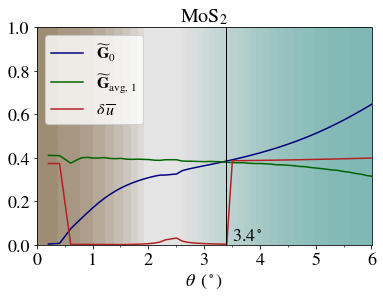

In [18]:
plt.clf()
plt.rc('font', size=16)
_, ax = plt.subplots()

FONT_SIZE = 18
# # interpolate degenerate points
M1_LB1_d0[5] = 1/2 * (M1_LB1_d0[4] + M1_LB1_d0[6])
M1_LB1_dm[5] = 1/2 * (M1_LB1_dm[4] + M1_LB1_dm[6])
M1_LB1_mean[5] = 1/2 * (M1_LB1_mean[4] + M1_LB1_mean[6])
M1_LB1_d0[24] = 1/2 * (M1_LB1_d0[23] + M1_LB1_d0[25])
M1_LB1_dm[24] = 1/2 * (M1_LB1_dm[23] + M1_LB1_dm[25])
M1_LB1_mean[24] = 1/2 * (M1_LB1_mean[23] + M1_LB1_mean[25])

gradient_image(0, ax, (0, 6, 0, 1))

ax.plot(M1_thetas[CUT:], M1_LB1_d0[CUT:], color='navy', label=r'$\widetilde{\mathbf{G}}_0$')
# ax.plot(M2_thetas[CUT:], M2_LB1_d1[CUT:], color='sienna', label=r'$G_1$')
# ax.plot(M2_thetas[CUT:], M2_LB1_d2[CUT:], color='olivedrab', label=r'$G_2$')
# ax.plot(M2_thetas[CUT:], M2_LB1_d3[CUT:], color='darkmagenta', label=r'$G_3$')
ax.plot(M1_thetas[CUT:], M1_LB1_dm[CUT:], color='darkgreen', label=r'$\widetilde{\mathbf{G}}_{\mathrm{avg},\, 1}$')
# ax.plot(M2_thetas[CUT:], p(M2_thetas[CUT:]), color='green', label=r'Fit')
ax.plot(M1_thetas[CUT:], M1_LB1_mean[CUT:], color='firebrick', label=r'$\delta \,\overline{u}$')
ax.legend(loc='upper left')

# ax.set_yscale("log")
ax.set_xticks(np.arange(6+1))
ax.set_xlim((0,6))
# ax.set_ylabel(r'Average over real space (a.u.)', fontsize=FONT_SIZE)
ax.set_xlabel(r'$\theta \;\;(^\circ)$', fontsize=FONT_SIZE)
ax.set_ylim(0, 1)
plt.yticks(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
ax.plot([3.4]*2, ax.get_ylim(), color='k', linewidth=1)
ax.text(3.5, 0.02, r'$3.4^\circ$', fontsize=FONT_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_title(r"MoS$_2$", fontsize=FONT_SIZE+2)
plt.savefig("/Users/jonathanlu/Documents/data_mlph/MoS2_G.pdf", bbox_inches='tight')

## Gr

In [19]:
DIRNAME = "tvGr" 
ROOT = '/Users/jonathanlu/Documents/'
THSPC_DIR = 'theta'

# Change as necessary
M2_th_min, M2_th_max, M2_ntheta = np.loadtxt(f"{ROOT}/{DIRNAME}/theta.txt")
M2_ntheta = int(M2_ntheta)
KPT = 'Gamma'
print(f"{M2_ntheta} angles from {M2_th_min} to {M2_th_max}")
M2_masses = np.load(f"{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/masses.npy")
M2_mean_mass = np.mean(M2_masses)
print("Average mass:", M2_mean_mass)

# Import dataset from the directory
log_name = r'$\Gamma$' if KPT == 'Gamma' else KPT
path = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/thspc_mags.npy'
ppath = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/thspc_phonons.npy'
poscars_uc = [Poscar.from_file(f'{ROOT}/{DIRNAME}/POSCAR_LAYER{i+1}') for i in range(2)]
M2_dataset = np.load(path) * np.sqrt(M2_mean_mass)
fpath = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/fourier.npy'
M2_fourier = np.transpose(np.load(fpath), axes=(2,0,1,3,4))
M2_fourier = np.mean([blk / np.sqrt(m) for blk, m in zip(M2_fourier, M2_masses)], axis=0) * np.sqrt(M2_mean_mass)
M2_phonons = np.load(ppath)
M2_nmodes = M2_dataset.shape[1]
print("Dataset shape:", M2_dataset.shape)
print("Number of modes:", M2_nmodes)
M2_thetas = np.linspace(M2_th_min, M2_th_max, M2_ntheta)

101 angles from 0.01 to 10.0
Average mass: 12.0107
Dataset shape: (101, 61, 1521, 3)
Number of modes: 61


In [20]:
d = np.transpose(np.load(fpath), axes=(0,3,2,1,4))
d0 = LA.norm(d[:,:,:,0].reshape((101, 61, -1)), axis=-1)
d1 = LA.norm(d[:,:,:,1].reshape((101, 61, -1)), axis=-1) 
d2 = LA.norm(d[:,:,:,2].reshape((101, 61, -1)), axis=-1)
d3 = LA.norm(d[:,:,:,3].reshape((101, 61, -1)), axis=-1)  
M2_mean_umag = np.mean(LA.norm(M2_dataset, axis=-1), axis=2)

In [21]:
# Import the indices and extract the modes
M2_LB1_idxs = np.load(f'{ROOT}/{DIRNAME}/{THSPC_DIR}/data/Gr_LB1_idxs.npy')
M2_S_idxs = np.load(f'{ROOT}/{DIRNAME}/{THSPC_DIR}/data/Gr_S_idxs.npy')

M2_LB1_d0 = np.zeros(M2_ntheta)
M2_LB1_d1 = np.zeros(M2_ntheta)
M2_LB1_d2 = np.zeros(M2_ntheta)
M2_LB1_d3 = np.zeros(M2_ntheta)
M2_LB1_mean = np.zeros(M2_ntheta)

for i in range(M2_ntheta):
    M2_LB1_d0[i] = d0[i, M2_LB1_idxs[i]]
    M2_LB1_d1[i] = d1[i, M2_LB1_idxs[i]]
    M2_LB1_d2[i] = d2[i, M2_LB1_idxs[i]]
    M2_LB1_d3[i] = d3[i, M2_LB1_idxs[i]]
    M2_LB1_mean[i] = M2_mean_umag[i, M2_LB1_idxs[i]]
    
M2_LB1_dm = np.mean([M2_LB1_d1, M2_LB1_d2, M2_LB1_d3], axis=0)
M2_LB1_dv = np.var([M2_LB1_d1, M2_LB1_d2, M2_LB1_d3], axis=0)
CUT = 2

<Figure size 432x288 with 0 Axes>

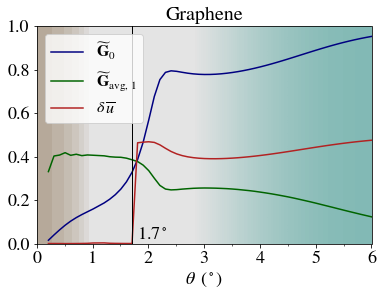

In [22]:
plt.clf()
plt.rc('font', size=16)
_, ax = plt.subplots()

FONT_SIZE = 18
# interpolate degenerate points
M2_LB1_d0[11] = 1/2 * (M2_LB1_d0[10] + M2_LB1_d0[12])
M2_LB1_d1[11] = 1/2 * (M2_LB1_d1[10] + M2_LB1_d1[12])
M2_LB1_d2[11] = 1/2 * (M2_LB1_d2[10] + M2_LB1_d2[12])
M2_LB1_d3[11] = 1/2 * (M2_LB1_d3[10] + M2_LB1_d3[12])
M2_LB1_dm[11] = 1/2 * (M2_LB1_dm[10] + M2_LB1_dm[12])
M2_LB1_mean[11] = 1/2 * (M2_LB1_mean[10] + M2_LB1_mean[12])

gradient_image(1, ax, (0, 6, 0, 1))

ax.plot(M2_thetas[CUT:], M2_LB1_d0[CUT:], color='navy', label=r'$\widetilde{\mathbf{G}}_0$')
# ax.plot(M2_thetas[CUT:], M2_LB1_d1[CUT:], color='sienna', label=r'$G_1$')
# ax.plot(M2_thetas[CUT:], M2_LB1_d2[CUT:], color='olivedrab', label=r'$G_2$')
# ax.plot(M2_thetas[CUT:], M2_LB1_d3[CUT:], color='darkmagenta', label=r'$G_3$')
ax.plot(M2_thetas[CUT:], M2_LB1_dm[CUT:], color='darkgreen', label=r'$\widetilde{\mathbf{G}}_{\mathrm{avg},\, 1}$')
# ax.plot(M2_thetas[CUT:], p(M2_thetas[CUT:]), color='green', label=r'Fit')
ax.plot(M2_thetas[CUT:], M2_LB1_mean[CUT:], color='firebrick', label=r'$\delta \,\overline{u}$')
ax.legend(loc='upper left')

# ax.set_yscale("log")
ax.set_xticks(np.arange(6+1))
ax.set_xlim((0,6))
# ax.set_ylabel(r'Average over real space (a.u.)', fontsize=FONT_SIZE)
ax.set_xlabel(r'$\theta \;\;(^\circ)$', fontsize=FONT_SIZE)
ax.set_ylim(0, 1)
plt.yticks(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
ax.plot([1.7]*2, ax.get_ylim(), color='k', linewidth=1)
ax.text(1.8, 0.02, r'$1.7^\circ$', fontsize=FONT_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_title("Graphene", fontsize=FONT_SIZE+2)
plt.savefig("/Users/jonathanlu/Documents/data_mlph/Gr_G.pdf", bbox_inches='tight')

## Het

In [23]:
DIRNAME = "tvHet" 
ROOT = '/Users/jonathanlu/Documents/'
THSPC_DIR = 'theta'

# Change as necessary
M3_th_min, M3_th_max, M3_ntheta = np.loadtxt(f"{ROOT}/{DIRNAME}/theta.txt")
M3_ntheta = int(M2_ntheta)
KPT = 'Gamma'
print(f"{M3_ntheta} angles from {M3_th_min} to {M3_th_max}")
M3_masses = np.load(f"{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/masses.npy")[[0,2,3,1,4,5]]
M3_mean_mass = np.mean(M3_masses)
print("Average mass:", M3_mean_mass)

# Import dataset from the directory
log_name = r'$\Gamma$' if KPT == 'Gamma' else KPT
path = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/thspc_mags.npy'
ppath = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/thspc_phonons.npy'
poscars_uc = [Poscar.from_file(f'{ROOT}/{DIRNAME}/POSCAR_LAYER{i+1}') for i in range(2)]
M3_dataset = np.load(path) * np.sqrt(M3_mean_mass)
fpath = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/fourier.npy'
M3_fourier = np.transpose(np.load(fpath), axes=(2,0,1,3,4))
M3_fourier = np.mean([blk / np.sqrt(m) for blk, m in zip(M3_fourier, M3_masses)], axis=0) * np.sqrt(M3_mean_mass)
M3_phonons = np.load(ppath)
M3_nmodes = M3_dataset.shape[1]
print("Dataset shape:", M3_dataset.shape)
print("Number of modes:", M3_nmodes)
M3_thetas = np.linspace(M3_th_min, M3_th_max, M3_ntheta)

101 angles from 0.01 to 10.0
Average mass: 99.27
Dataset shape: (101, 61, 1521, 3)
Number of modes: 61


In [24]:
d = np.transpose(np.load(fpath), axes=(0,3,2,1,4))
print(d.shape)
d0 = LA.norm(d[:,:,:,0].reshape((101, 61, -1)), axis=-1)
d1 = LA.norm(d[:,:,:,1].reshape((101, 61, -1)), axis=-1) 
d2 = LA.norm(d[:,:,:,2].reshape((101, 61, -1)), axis=-1)
d3 = LA.norm(d[:,:,:,3].reshape((101, 61, -1)), axis=-1)  
d4 = LA.norm(d[:,:,:,4].reshape((101, 61, -1)), axis=-1) 
d5 = LA.norm(d[:,:,:,5].reshape((101, 61, -1)), axis=-1)
d6 = LA.norm(d[:,:,:,6].reshape((101, 61, -1)), axis=-1)  
M3_mean_umag = np.mean(LA.norm(M3_dataset, axis=-1), axis=2)

(101, 61, 6, 7, 3)


In [25]:
# Import the indices and extract the modes
M3_LB1_idxs = np.load(f'{ROOT}/{DIRNAME}/{THSPC_DIR}/data/Het_LB1_idxs.npy')
M3_S_idxs = np.load(f'{ROOT}/{DIRNAME}/{THSPC_DIR}/data/Het_S_idxs.npy')

M3_LB1_d0 = np.zeros(M3_ntheta)
M3_LB1_d1 = np.zeros(M3_ntheta)
M3_LB1_d2 = np.zeros(M3_ntheta)
M3_LB1_d3 = np.zeros(M3_ntheta)
M3_LB1_d4 = np.zeros(M3_ntheta)
M3_LB1_d5 = np.zeros(M3_ntheta)
M3_LB1_d6 = np.zeros(M3_ntheta)
M3_LB1_mean = np.zeros(M3_ntheta)

for i in range(M2_ntheta):
    M3_LB1_d0[i] = d0[i, M3_LB1_idxs[i]]
    M3_LB1_d1[i] = d1[i, M3_LB1_idxs[i]]
    M3_LB1_d2[i] = d2[i, M3_LB1_idxs[i]]
    M3_LB1_d3[i] = d3[i, M3_LB1_idxs[i]]
    M3_LB1_d4[i] = d4[i, M3_LB1_idxs[i]]
    M3_LB1_d5[i] = d5[i, M3_LB1_idxs[i]]
    M3_LB1_d6[i] = d6[i, M3_LB1_idxs[i]]
    M3_LB1_mean[i] = M3_mean_umag[i, M3_LB1_idxs[i]]
    
M3_LB1_dm = np.mean([M3_LB1_d1, M3_LB1_d2, M3_LB1_d3, M3_LB1_d4, M3_LB1_d5, M3_LB1_d6], axis=0)
M3_LB1_dv = np.var([M3_LB1_d1, M3_LB1_d2, M3_LB1_d3, M3_LB1_d4, M3_LB1_d5, M3_LB1_d6], axis=0)

<Figure size 432x288 with 0 Axes>

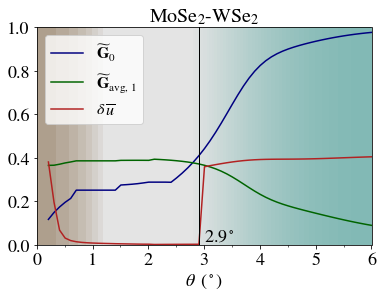

In [26]:
plt.clf()
plt.rc('font', size=16)
_, ax = plt.subplots()

FONT_SIZE = 18
# interpolate degenerate points
M3_LB1_d0[7:15] = 1/2 * (M3_LB1_d0[7] + M3_LB1_d0[15])
M3_LB1_d0[20:24] = 1/2 * (M3_LB1_d0[20] + M3_LB1_d0[24])
M3_LB1_dm[7:15] = 1/2 * (M3_LB1_dm[7] + M3_LB1_dm[15])
# M2_LB1_mean[11] = 1/2 * (M2_LB1_mean[10] + M2_LB1_mean[12])

gradient_image(2, ax, (0, 6, 0, 1))

ax.plot(M3_thetas[CUT:], M3_LB1_d0[CUT:], color='navy', label=r'$\widetilde{\mathbf{G}}_0$')
# ax.plot(M2_thetas[CUT:], M3_LB1_d4[CUT:], color='sienna', label=r'$G_1$')
# ax.plot(M2_thetas[CUT:], M3_LB1_d5[CUT:], color='olivedrab', label=r'$G_2$')
# ax.plot(M2_thetas[CUT:], M3_LB1_d6[CUT:], color='darkmagenta', label=r'$G_3$')
ax.plot(M3_thetas[CUT:], M3_LB1_dm[CUT:], color='darkgreen', label=r'$\widetilde{\mathbf{G}}_{\mathrm{avg},\, 1}$')
ax.plot(M3_thetas[CUT:], M3_LB1_mean[CUT:], color='firebrick', label=r'$\delta \,\overline{u}$')
ax.legend(loc='upper left')

# ax.set_yscale("log")
ax.set_xticks(np.arange(6+1))
ax.set_xlim((0,6))
# ax.set_ylabel(r'Average over real space (a.u.)', fontsize=FONT_SIZE)
ax.set_xlabel(r'$\theta \;\;(^\circ)$', fontsize=FONT_SIZE)
ax.set_ylim(0, 1)
plt.yticks(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
ax.plot([2.9]*2, ax.get_ylim(), color='k', linewidth=1)
ax.text(3.0, 0.02, r'$2.9^\circ$', fontsize=FONT_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_title(r"MoSe$_2$-WSe$_2$", fontsize=FONT_SIZE+2)
plt.savefig("/Users/jonathanlu/Documents/data_mlph/Het_G.pdf", bbox_inches='tight')

## Together we stand

<Figure size 432x288 with 0 Axes>

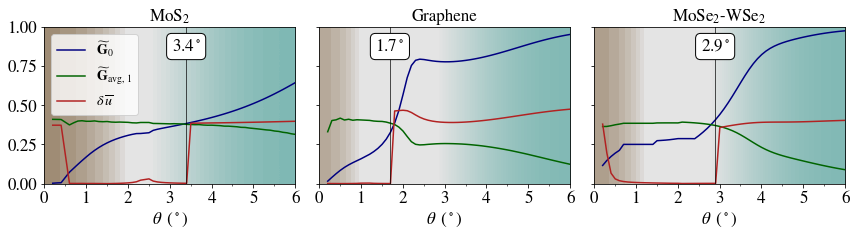

In [37]:
plt.clf()
plt.rc('font', size=14)
_, axes = plt.subplots(ncols=3, sharey=True, figsize=(12, 3.5))
FONT_SIZE = 17

M_d0 = [M1_LB1_d0, M2_LB1_d0, M3_LB1_d0]
M_dm = [M1_LB1_dm, M2_LB1_dm, M3_LB1_dm]
M_dv = [M1_LB1_dv, M2_LB1_dv, M3_LB1_dv]
M_mean = [M1_LB1_mean, M2_LB1_mean, M3_LB1_mean]
POINTS = [3.4, 1.7, 2.9]
MATERIALS = [r"MoS$_2$", 'Graphene', r"MoSe$_2$-WSe$_2$"]

for i, ax in enumerate(axes):
    gradient_image(i, ax, (0, 6, 0, 1))
    ax.plot(M3_thetas[CUT:], M_d0[i][CUT:], color='navy', label=r'$\widetilde{\mathbf{G}}_0$')
    ax.plot(M3_thetas[CUT:], M_dm[i][CUT:], color='darkgreen', label=r'$\widetilde{\mathbf{G}}_{\mathrm{avg},\, 1}$')
    ax.plot(M3_thetas[CUT:], M_mean[i][CUT:], color='firebrick', label=r'$\delta \, \overline{u}$')
    # ax.plot(M3_thetas[CUT:], M_dv[i][CUT:], color='magenta', label='Var')
    ax.set_xticks(np.arange(6+1))
    ax.set_xlim((0,6))
    ax.set_xlabel(r'$\theta \;\;(^\circ)$', fontsize=FONT_SIZE)
    ax.set_ylim(0, 1)
    ax.tick_params('both', labelsize=FONT_SIZE)
    ax.plot([POINTS[i]]*2, ax.get_ylim(), color='k', linewidth=0.67)
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    ax.text(POINTS[i]-.35, 0.85, str(POINTS[i]) + r'$^\circ$', fontsize=FONT_SIZE,
            bbox=props)
    
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.set_title(MATERIALS[i], fontsize=FONT_SIZE)

axes[0].legend()
plt.tight_layout()
plt.savefig("/Users/jonathanlu/Documents/data_mlph/Mags_G.pdf", bbox_inches='tight')